# 목차

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [3]:
listings_df = pd.read_csv('listings.csv')
reviews_df = pd.read_csv('reviews.csv')
calendar_df = pd.read_csv('calendar.csv')

In [4]:
calendar_df.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,10110295,2025-09-29,f,NaN,NaN,1,90
1,10110295,2025-09-30,f,NaN,NaN,1,90
2,10110295,2025-10-01,f,NaN,NaN,1,90
3,10110295,2025-10-02,f,NaN,NaN,1,90
4,10110295,2025-10-03,t,NaN,NaN,1,90


In [5]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,10110295,58689189,2016-01-03,51451696,Kristine Sheelah,The place is perfect for foreign visitors sinc...
1,10110295,60602395,2016-01-25,52932795,Hiu Tung,Good location 8 mins from Shibuya station. Siz...
2,10110295,61192393,2016-02-01,20192765,Charlene,"right smack in the prime area, food was litera..."
3,10110295,62364939,2016-02-14,52751056,Gaëlle,Its a very good appartment. The host answer ve...
4,10110295,63247426,2016-02-21,58108765,Jessica,"Great location, and great directions! We got i..."


## 데이터 변환

In [6]:
# id 컬럼 string으로 변환
listings_df['id'] = listings_df['id'].astype('string')
listings_df['host_id'] = listings_df['host_id'].astype('string')
listings_df['scrape_id'] = listings_df['scrape_id'].astype('string')

# t : 1, f : 0로 변환
listings_df = listings_df.replace({'f': 0, 't': 1})
listings_df.replace({'%': ''}, regex=True, inplace=True)
listings_df['price'] = listings_df['price'].astype(str).str.replace("$", "", regex=False).str.replace(",", "", regex=False)

# datetime 형식으로 변환
listings_df['last_scraped'] = pd.to_datetime(listings_df['last_scraped'])
listings_df['calendar_last_scraped'] = pd.to_datetime(listings_df['calendar_last_scraped'])
listings_df['host_since'] = pd.to_datetime(listings_df['host_since'])
listings_df['first_review'] = pd.to_datetime(listings_df['first_review'])
listings_df['last_review'] = pd.to_datetime(listings_df['last_review'])

# 숫자형으로 변환
cols = ['price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']
listings_df[cols] = listings_df[cols].apply(pd.to_numeric, errors='coerce')

# rate 변환
listings_df['host_response_rate'] = pd.to_numeric(listings_df['host_response_rate'], errors='coerce')/100
listings_df['host_acceptance_rate'] = pd.to_numeric(listings_df['host_acceptance_rate'], errors='coerce')/100

# host_verifications 컬럼 전처리
verifications = listings_df['host_verifications'].astype(str).str.strip("[]").str.replace("'", "").str.replace(", ", "|").str.get_dummies(sep='|').drop(columns='nan',axis=1)
listings_df.drop(columns=['host_verifications'], axis=1, inplace=True)
listings_df = pd.concat([listings_df, verifications], axis=1)

# 나머지 object 타입 string으로 변환
listings_df = listings_df.astype({col: 'string' for col in listings_df.select_dtypes('object').columns})

# 분석용 price 로그 변환
listings_df['log_price'] = np.log1p(listings_df['price'])

# 사용하지 않는 데이터 제거
listings_df.drop(columns=['listing_url', 'scrape_id', 'last_scraped', 'source','picture_url','host_url','host_thumbnail_url','host_picture_url'], axis=1, inplace=True)
listings_df.drop(columns=['calendar_updated', 'neighbourhood_group_cleansed', 'neighbourhood'], axis=1, inplace=True)

C:\Users\songj\AppData\Local\Temp\ipykernel_25936\3758298724.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  listings_df = listings_df.replace({'f': 0, 't': 1})


## 파생변수

In [7]:
# 기준연도 2025-09-29
listings_df['host_experience_days'] = (pd.to_datetime('2025-09-29') - listings_df['host_since']).dt.days
listings_df['host_experience_years'] = listings_df['host_experience_days'] / 365

# 데이터 Overview

## listings

In [8]:
listings_df.head()

,id,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,email,phone,work_email,log_price,host_experience_days,host_experience_years
0,197677,Oshiage Holiday Apartment,<NA>,<NA>,964081,Yoshimi & Marek,2011-08-13,"Tokyo, Japan",Would love to travel all over the world and me...,within a day,1.0,0.89,1.0,Sumida District,1.0,2.0,1.0,1.0,Sumida Ku,35.71707,139.82608,Entire rental unit,Entire home/apt,2,1.0,1 bath,1.0,2.0,"[""Hangers"", ""Hot water"", ""Shampoo"", ""Iron"", ""F...",12600.0,3,1125,1.0,3.0,1125.0,1125.0,3.0,1125.0,1.0,5,22,27,183,2025-09-30,190,10,0,27,9,60,756000.0,2011-09-21,2025-08-24,4.78,4.76,4.91,4.85,4.84,4.58,4.80,M130003350,0,1,1,0,0,1.11,1,1,0,9.441531,5161.0,14.139726
1,776070,Kero-kero room 1F,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,801494,Kei,2011-07-10,Japan,Thank you for looking at our profile.\nI am Ke...,within an hour,1.0,1.00,1.0,Kita District,1.0,4.0,1.0,1.0,Kita Ku,35.73844,139.76917,Private room in home,Private room,1,1.0,1 shared bath,1.0,1.0,"[""Extra pillows and blankets"", ""Ethernet conne...",10459.0,3,14,1.0,1.0,14.0,14.0,1.0,14.0,1.0,0,0,0,76,2025-09-29,272,14,0,0,15,84,878556.0,2012-11-28,2025-05-21,4.98,4.97,4.92,4.98,4.98,4.85,4.92,M130000243,0,1,0,1,0,1.74,1,1,0,9.255314,5195.0,14.232877
2,905944,4F Spacious Apartment in Shinjuku / Shibuya Tokyo,NEWLY RENOVATED property entirely for you & yo...,Hatagaya is a great neighborhood located 4 min...,4847803,Best Stay In Tokyo!,2013-01-25,"Tokyo, Japan",A host backed up by a team of professional cle...,within an hour,1.0,1.00,1.0,Shibuya District,9.0,17.0,1.0,1.0,Shibuya Ku,35.67878,139.67847,Entire rental unit,Entire home/apt,6,1.5,1.5 baths,2.0,4.0,"[""Extra pillows and blankets"", ""Ethernet conne...",33671.0,5,1125,1.0,20.0,365.0,1125.0,6.0,679.4,1.0,2,10,40,305,2025-09-29,281,50,3,40,42,255,8586105.0,2013-04-07,2025-09-21,4.82,4.83,4.82,4.89,4.93,4.81,4.81,Hotels and Inns Business Act | 渋谷区保健所長 | 31渋健生...,1,9,9,0,0,1.85,1,1,0,10.424422,4630.0,12.684932
3,1016831,5 mins Shibuya Cat modern sunny Shimokita,"Hi there, I am Wakana and I live with my two f...",The location is walkable distance to famous Sh...,5596383,Wakana,2013-03-24,"Tokyo, Japan","Hi there, I am Wakana! I am an openminded, fri...",within an hour,0.9,0.89,1.0,Shimokitazawa,1.0,6.0,1.0,1.0,Setagaya Ku,35.65800,139.67134,Private room in home,Private room,2,1.0,1 shared bath,1.0,4.0,"[""Extra pillows and blankets"", ""Ethernet conne...",24143.0,1,14,1.0,1.0,14.0,14.0,1.0,14.0,1.0,17,47,70,80,2025-09-29,284,16,1,73,12,96,2317728.0,2013-04-06,2025-09-21,4.95,4.94,4.85,4.94,4.98,4.93,4.89,M130001107,0,1,0,1,0,1.87,1,1,0,10.091791,4572.0,12.526027
4,1196177,Homestay at Host's House - Senju-Ohashi Station,Our accommodation offers: <br /><br />1. **Gr...,There are shopp

In [9]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27945 entries, 0 to 27944
Data columns (total 73 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            27945 non-null  string        
 1   name                                          27945 non-null  string        
 2   description                                   27458 non-null  string        
 3   neighborhood_overview                         14819 non-null  string        
 4   host_id                                       27945 non-null  string        
 5   host_name                                     27938 non-null  string        
 6   host_since                                    27937 non-null  datetime64[ns]
 7   host_location                                 19831 non-null  string        
 8   host_about                                    19782 non-null  stri

In [10]:
listings_df.describe()

,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,email,phone,work_email,log_price,host_experience_days,host_experience_years
count,27937,27244.000000,27525.000000,25929.000000,27937.000000,27937.000000,27937.000000,27937.000000,27945.000000,27945.000000,27945.000000,25482.000000,27637.000000,25486.000000,2.548000e+04,27945.000000,27945.000000,27930.000000,27930.000000,27930.000000,27930.000000,27945.000000,27945.000000,27826.0,27945.000000,27945.000000,27945.000000,27945.000000,27945,27945.000000,27945.000000,27945.00000,27945.000000,27945.000000,27945.000000,2.548000e+04,24009,24009,24009.000000,24008.000000,24008.000000,24008.000000,24008.000000,24008.000000,24008.000000,27945.000000,27945.000000,27945.000000,27945.000000,27945.000000,24009.000000,27945.000000,27945.000000,27945.000000,25480.000000,27937.000000,27937.000000
mean,2021-01-05 01:53:36.250849792,0.990387,0.973496,0.441012,32.116333,43.048967,0.989512,0.969431,35.698246,139.737804,4.466380,1.159681,1.422188,2.962018,2.478188e+04,5.317373,342.541242,4.899427,7.030648,484.572001,518.959649,5.668753,504.371412,1.0,7.316336,19.471855,38.218286,170.259939,2025-09-29 10:23:42.995169024,35.965361,13.342172,1.01256,39.988621,10.091680,80.683020,1.843235e+06,2023-06-26 16:02:56.333874688,2025-06-30 13:14:09.731350528,4.732936,4.769036,4.714660,4.795333,4.838685,4.721677,4.681906,0.775273,25.348756,23.108892,1.937914,0.253104,1.675255,0.879943,0.998604,0.038719,9.765136,1727.921108,4.734030
min,2010-12-19 00:00:00,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,35.520940,139.081322,1.000000,0.000000,0.000000,0.000000,1.500000e+03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,2025-09-29 00:00:00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,2011-09-21 00:00:00,2018-12-27 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,7.313887,2.000000,0.005479
25%,2018-05-14 00:00:00,1.000000,0.980000,0.000000,5.000000,6.000000,1.000000,1.000000,35.686990,139.699730,2.000000,1.000000,1.000000,2.000000,1.120150e+04,1.000000,180.000000,1.000000,1.000000,365.000000,365.000000,1.000000,365.000000,1.0,2.000000,8.000000,21.000000,99.000000,2025-09-29 00:00:00,2.000000,1.000000,0.00000,22.000000,0.000000,12.000000,2.280000e+05,2022-11-28 00:00:00,2025-07-05 00:00:00,4.640000,4.690000,4.610000,4.730000,4.800000,4.620000,4.580000,1.000000,4.000000,2.000000,0.000000,0.000000,0.720000,1.000000,1.000000,0.000000,9.323892,619.000000,1.695890
50%,2021-10-01 00:00:00,1.000000,1.000000,0.000000,14.000000,17.000000,1.000000,1.000000,35.704133,139.729038,4.000000,1.000000,1.000000,2.000000,1.620000e+04,2.000000,365.000000,1.000000,2.000000,365.000000,365.000000,2.000000,365.000000,1.0,5.000000,16.000000,37.000000,159.000000,2025-09-29 00:00:00,16.000000,8.000000,0.00000,39.000000,2.000000,60.000000,9.122820e+05,2024-05-26 00:00:00,2025-09-03

1. 호스트 정보 (Host Information)

|컬럼명|의미|
|---|---|
|host_id|호스트 고유 ID|
|host_since|호스트 가입 날짜|
|host_response_time|문의 응답에 걸리는 평균 시간|
|host_response_rate|문의 응답률 (0~1)|
|host_acceptance_rate|예약 수락률 (0~1)|
|host_is_superhost|슈퍼호스트 여부 (1/0)|
|host_listings_count|호스트가 등록한 총 숙소 수|
|host_identity_verified|호스트 신원 인증 여부 (1/0)|

2. 숙소 및 위치 정보 (Property & Location)

|컬럼명|의미|
|---|---|
|neighbourhood_cleansed|정제된 행정 구역명 (도쿄의 '구' 단위)|
|latitude |숙소의 위도 좌표|
|longitude|숙소의 경도 좌표|
|property_type|"숙소의 구체적 형태 (아파트, 빌라 등)"|
|room_type|"방 타입 (집 전체, 개인실, 다인실 등)"|
|accommodates|최대 수용 가능 인원|
|bathrooms_text|욕실 수 및 형태 (문구)|
|bedrooms|침실 개수|
|beds|침대 개수|
|amenities|제공 편의시설 리스트|

3. 가격 및 예약 규칙 (Price & Rules)

|컬럼명|의미|
|---|---|
|price|1박당 숙박 가격 (정제 후 단위: 엔)|
|log_price|분석용 로그 변환 가격|
|minimum_nights|최소 숙박 필요 일수|
|maximum_nights|최대 숙박 가능 일수|
|minimum_minimum_nights|기간별 최소 숙박 설정 중 가장 짧은 값|
|maximum_minimum_nights|기간별 최소 숙박 설정 중 가장 긴 값|
|minimum_nights_avg_ntm|향후 1년 평균 최소 숙박 일수|

4. 예약 가용성 및 가동률 (Availability & Performance)

|컬럼명|의미|
|---|---|
|has_availability|현재 예약 가능 여부 (1/0)|
|availability_30 / 60 / 90 / 365|향후 해당 일수 중 예약 가능한 날짜 수|
|estimated_occupancy_l365d|향후 1년 예상 가동률(점유율)|
|estimated_revenue_l365d|향후 1년 예상 매출액|
|instant_bookable|즉시 예약 가능 여부 (1/0)|
5. 리뷰 및 평점 (Reviews & Scores)

|컬럼명|의미|
|---|---|
|number_of_reviews|전체 리뷰 개수|
|number_of_reviews_ltm|최근 12개월간 리뷰 개수|
|first_review / last_review|첫 리뷰일 / 마지막 리뷰일|
|review_scores_rating|숙소 전체 평점|
|review_scores_accuracy|정보 정확도 평점|
|review_scores_cleanliness|청결도 평점|
|review_scores_checkin|체크인 만족도 평점|
|review_scores_communication|소통 만족도 평점|
|review_scores_location|위치 만족도 평점|
|review_scores_value|가성비 평점|
|reviews_per_month|월평균 리뷰 개수 (인기 지표)|

# 데이터 전처리

## 중복 처리

In [29]:
listings_df.duplicated().sum()

0

## 결측치 처리

In [30]:
listings_df.isna().mean().sort_values(ascending=False).head(28)*100
# calendar_updated, neighbourhood_group_cleansed 전부 결측, 따라서 컬럼 제거

host_neighbourhood             73.809268
neighborhood_overview          46.970836
host_about                     29.210950
host_location                  29.035606
review_scores_checkin          14.088388
review_scores_value            14.088388
review_scores_location         14.088388
review_scores_accuracy         14.088388
review_scores_communication    14.088388
review_scores_cleanliness      14.088388
reviews_per_month              14.084809
review_scores_rating           14.084809
last_review                    14.084809
first_review                   14.084809
log_price                       8.820898
price                           8.820898
estimated_revenue_l365d         8.820898
bathrooms                       8.813741
beds                            8.799427
host_is_superhost               7.214171
host_response_time              2.508499
host_response_rate              2.508499
description                     1.742709
host_acceptance_rate            1.502952
bedrooms        

In [31]:
# 리뷰에 관한 결측치에서 값이 다른 것을 발견
listings_df[(listings_df['last_review'].notna())&(listings_df['review_scores_value'].isna())].index

Index([27335], dtype='int64')

In [32]:
# last_review가 존재하는데 review_scores_value가 결측인 경우는 이상치로 판단, 해당 행 제거
listings_df.drop(index=listings_df[(listings_df['last_review'].notna())&(listings_df['review_scores_value'].isna())].index, inplace=True)

In [33]:
# price를 제거하고 나면, 나머지 결측치는 1% 미만의 비율이므로 해당 행 제거
listings_df = listings_df.dropna(subset=['price','license','bedrooms','bathrooms','beds','host_experience_days'])

In [34]:
listings_df[listings_df['bathrooms'].isna()]

,id,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,email,phone,work_email,log_price,host_experience_days,host_experience_years


## 이상치 처리

In [35]:
print(listings_df['price'].describe().round())
print(listings_df['price'].value_counts().sort_index().tail(15))

count      25439.0
mean       24788.0
std        77923.0
min         1500.0
25%        11214.0
50%        16200.0
75%        25052.0
max      9999998.0
Name: price, dtype: float64
price
501043.0     1
502429.0     1
515715.0     1
552000.0     1
728857.0     1
799999.0     6
815812.0     1
849712.0     1
850400.0     1
948915.0     1
969999.0     1
999999.0     3
1103381.0    1
1742858.0    1
9999998.0    1
Name: count, dtype: int64


<Axes: xlabel='log_price', ylabel='Density'>

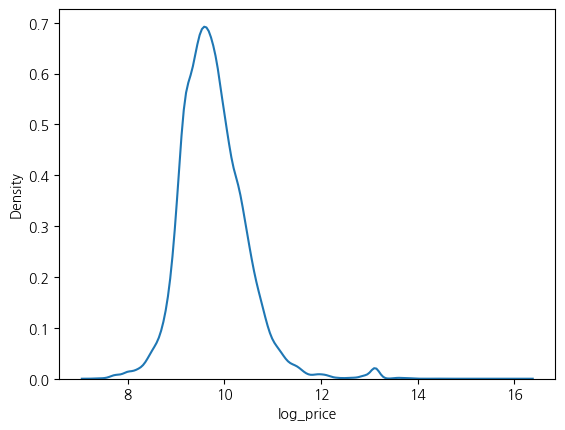

In [36]:
# IQR의 3배수를 벗어나는 극단치로 판단
sns.kdeplot(data=listings_df, x='log_price')

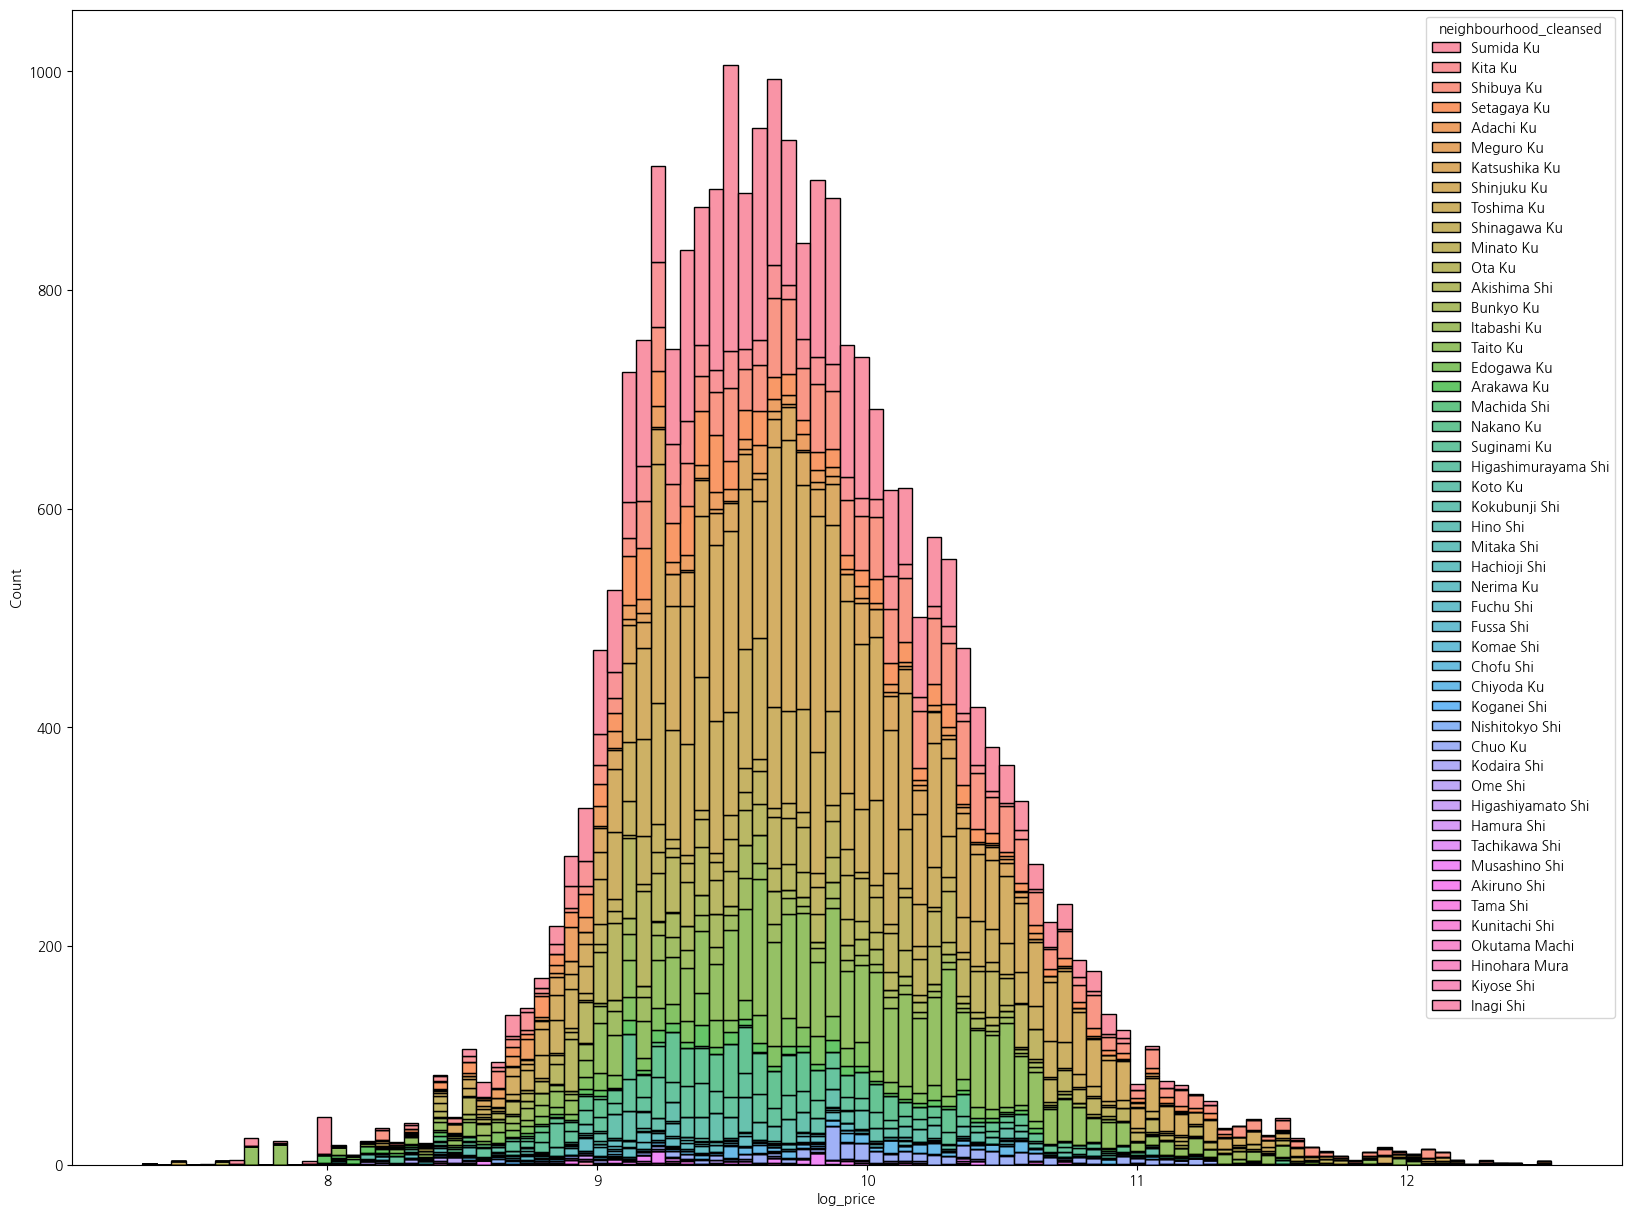

In [37]:
# log_price 기준으로 IQR 계산
Q1 = listings_df['log_price'].quantile(0.25)
Q3 = listings_df['log_price'].quantile(0.75)
IQR = Q3 - Q1

# 3.0배수를 적용하여 아주 멀리 떨어진 이상치만 제거 (Luxury 보존)
upper_bound = Q3 + 3.0 * IQR

# 필터링 적용
listings_df = listings_df[listings_df['log_price'] <= upper_bound]

# 다시 그래프 그리기
plt.figure(figsize=(20,15))
ax = sns.histplot(data=listings_df, x='log_price', hue='neighbourhood_cleansed', multiple="stack")
sns.move_legend(ax, "best", bbox_to_anchor=(1, 1))
plt.show()

In [38]:
listings_df.to_csv('listings_cleaned.csv', index=False)

# 시각화 및 그래프

C:\Users\songj\AppData\Local\Temp\ipykernel_14184\3508657447.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price_by_hood.values, y=avg_price_by_hood.index, palette='viridis')


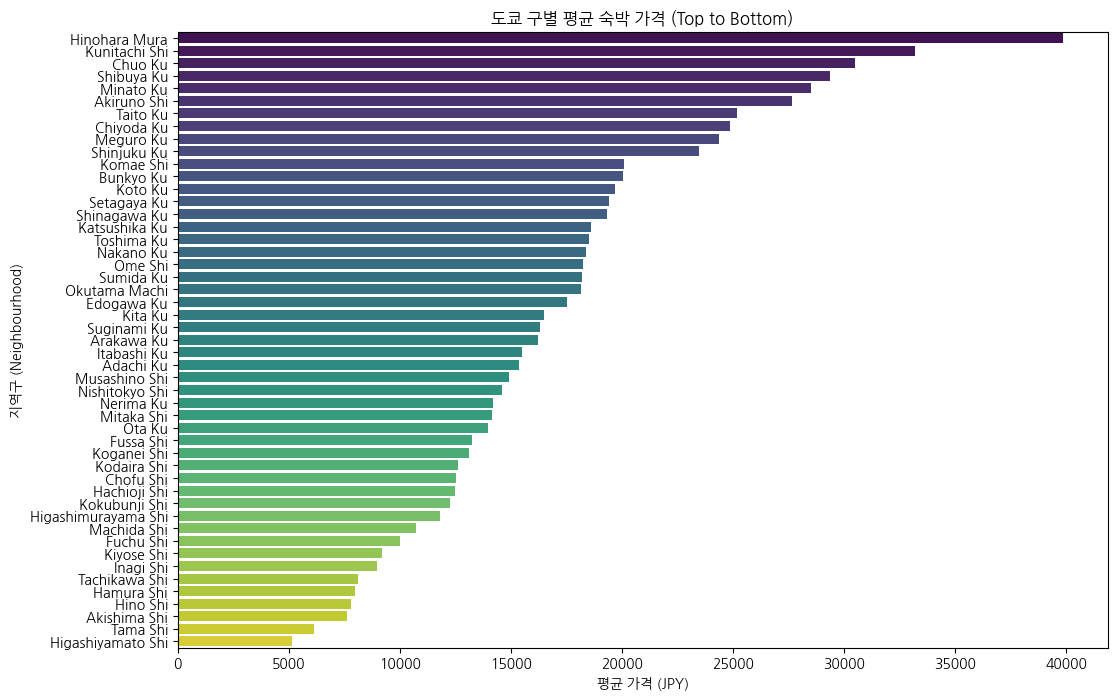

In [19]:
# 지역별 평균 가격 계산 및 정렬
avg_price_by_hood = listings_df.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=avg_price_by_hood.values, y=avg_price_by_hood.index, palette='viridis')
plt.title('도쿄 구별 평균 숙박 가격 (Top to Bottom)')
plt.xlabel('평균 가격 (JPY)')
plt.ylabel('지역구 (Neighbourhood)')
plt.savefig('price_by_neighbourhood.png')

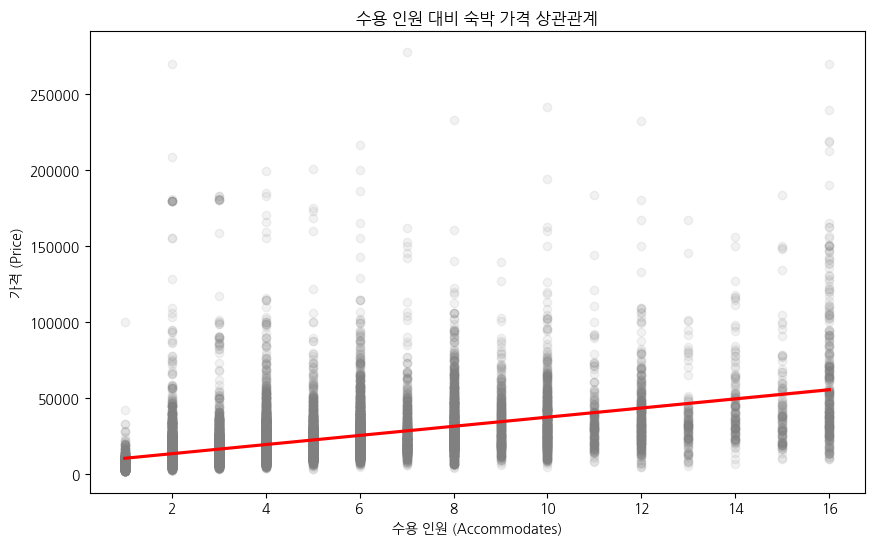

In [20]:
plt.figure(figsize=(10, 6))
# 이상치 영향을 줄이기 위해 포인트 크기 조절 및 회귀선 추가
sns.regplot(data=listings_df, x='accommodates', y='price', 
            scatter_kws={'alpha':0.1, 'color':'gray'}, line_kws={'color':'red'})
plt.title('수용 인원 대비 숙박 가격 상관관계')
plt.xlabel('수용 인원 (Accommodates)')
plt.ylabel('가격 (Price)')
plt.savefig('price_vs_capacity.png')

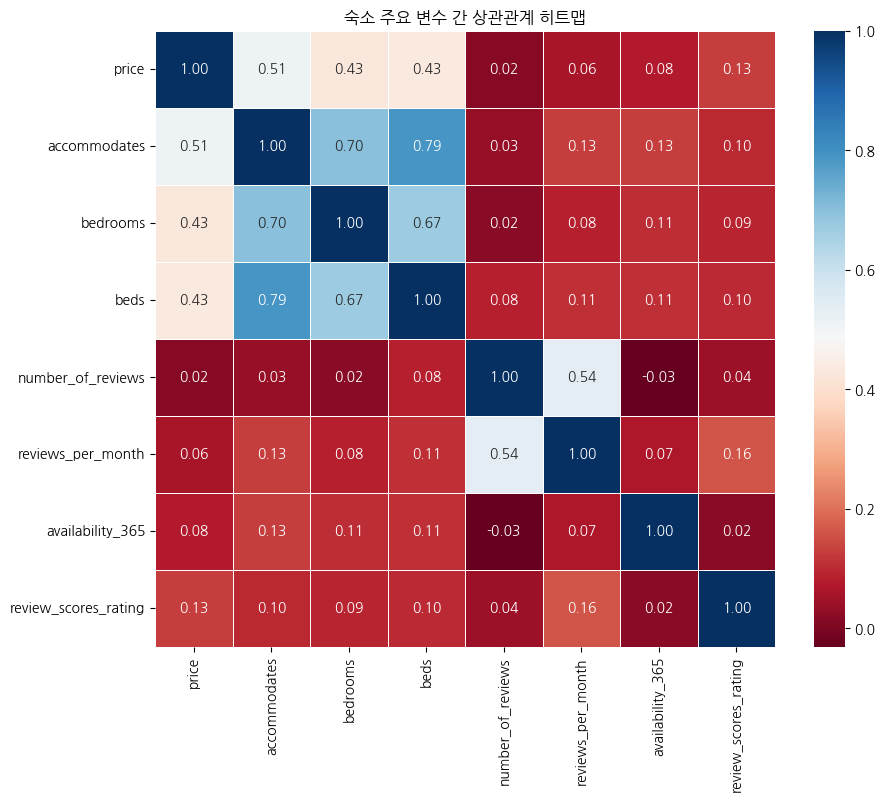

In [22]:
# 수치형 변수들만 선택
cols = ['price', 'accommodates', 'bedrooms', 'beds', 'number_of_reviews', 
        'reviews_per_month', 'availability_365', 'review_scores_rating']
corr_matrix = listings_df[cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt='.2f', linewidths=0.5)
plt.title('숙소 주요 변수 간 상관관계 히트맵')
plt.savefig('correlation_heatmap.png')

C:\Users\songj\AppData\Local\Temp\ipykernel_14184\1478567738.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=listings_df, x='host_is_superhost', y='log_price', ax=axes[0], palette='Set2')
C:\Users\songj\AppData\Local\Temp\ipykernel_14184\1478567738.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=listings_df, x='host_is_superhost', y='review_scores_rating', ax=axes[1], palette='Set2')


Text(0.5, 1.0, '슈퍼호스트 여부에 따른 평점 분포')

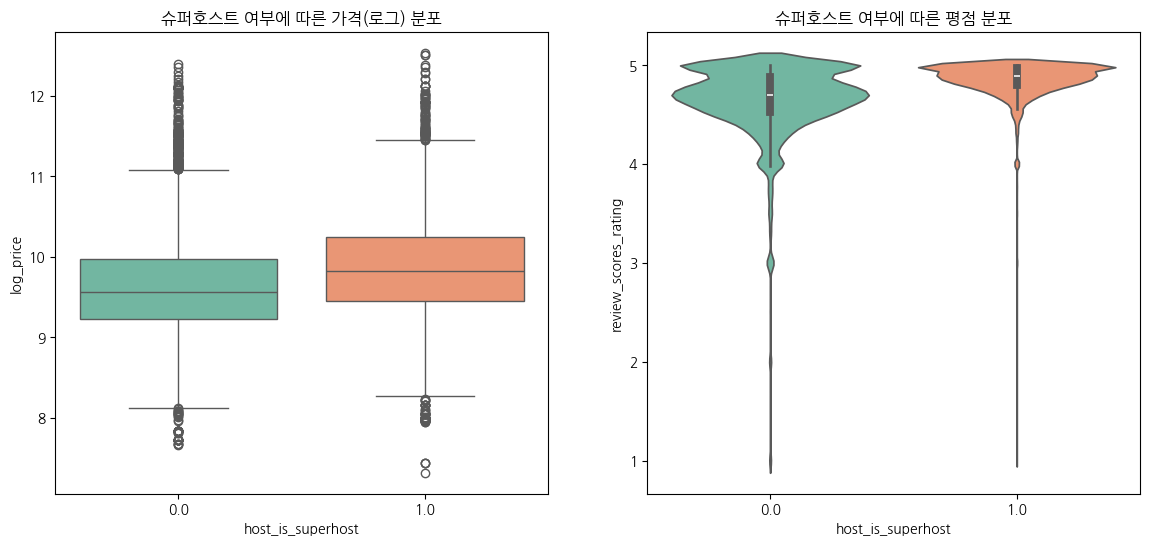

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. 가격 비교
sns.boxplot(data=listings_df, x='host_is_superhost', y='log_price', ax=axes[0], palette='Set2')
axes[0].set_title('슈퍼호스트 여부에 따른 가격(로그) 분포')

# 2. 평점 비교
sns.violinplot(data=listings_df, x='host_is_superhost', y='review_scores_rating', ax=axes[1], palette='Set2')
axes[1].set_title('슈퍼호스트 여부에 따른 평점 분포')
# 슈퍼호스트가 더 높은 평점을 받는 것인지, 더 높은 평점을 받아야 슈퍼호스트가 되는 것인지에 대해서는 인과관계는 모름
# 그러나 상관관계가 존재하기에 슈퍼호스트 제도가 평점 향상에 긍정적 영향을 미칠 가능성은 있음

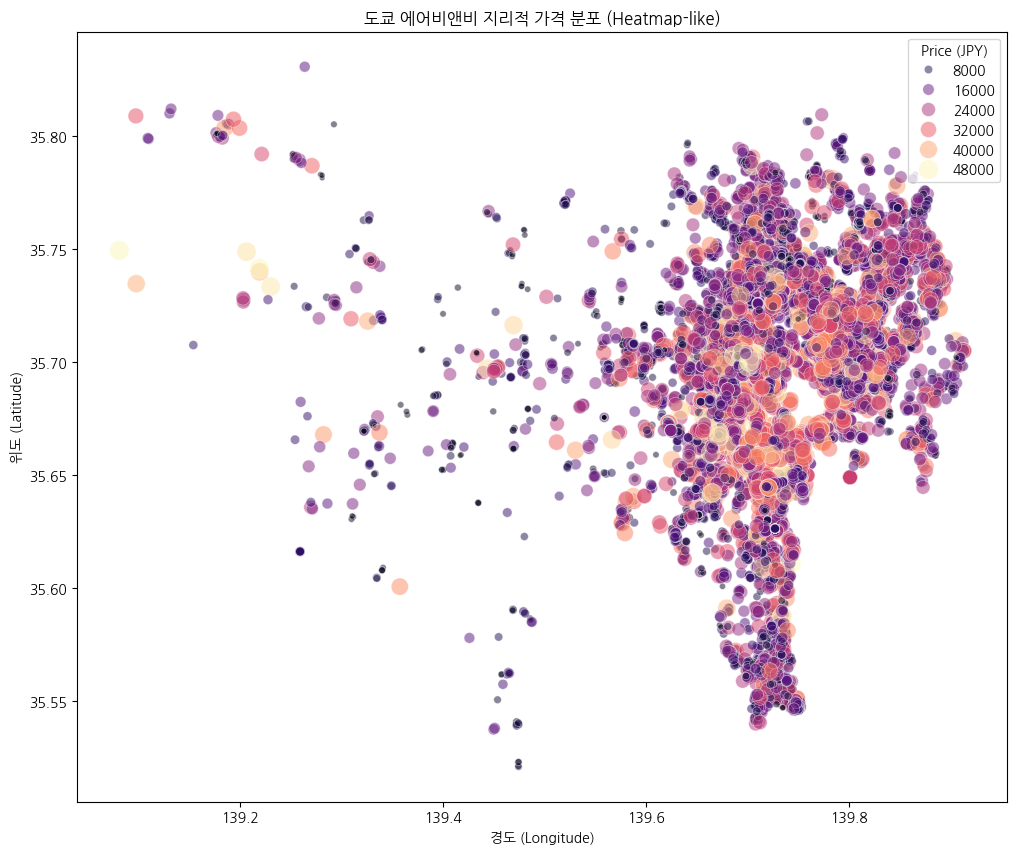

In [23]:
plt.figure(figsize=(12, 10))
# 가격 상위 1%를 제외하고 시각화하여 왜곡 방지
sns.scatterplot(data=listings_df[listings_df['price'] < listings_df['price'].quantile(0.95)], 
                x='longitude', y='latitude', hue='price', size='price',
                palette='magma', sizes=(10, 200), alpha=0.5)
plt.title('도쿄 에어비앤비 지리적 가격 분포 (Heatmap-like)')
plt.xlabel('경도 (Longitude)')
plt.ylabel('위도 (Latitude)')
plt.legend(title='Price (JPY)', loc='upper right')
plt.show()

C:\Users\songj\AppData\Local\Temp\ipykernel_14184\1857737564.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=listings_df, x='stay_type', y='log_price', palette='Set3')


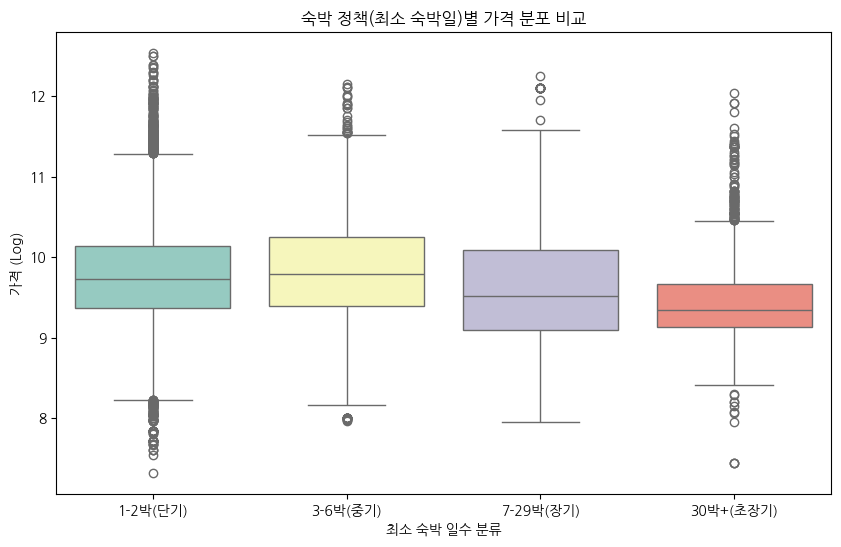

In [24]:
# 최소 숙박일 그룹화 (1-2박, 3-6박, 7-29박, 30박 이상)
bins = [0, 2, 6, 29, 1000]
labels = ['1-2박(단기)', '3-6박(중기)', '7-29박(장기)', '30박+(초장기)']
listings_df['stay_type'] = pd.cut(listings_df['minimum_nights'], bins=bins, labels=labels)

plt.figure(figsize=(10, 6))
sns.boxplot(data=listings_df, x='stay_type', y='log_price', palette='Set3')
plt.title('숙박 정책(최소 숙박일)별 가격 분포 비교')
plt.xlabel('최소 숙박 일수 분류')
plt.ylabel('가격 (Log)')
plt.show()

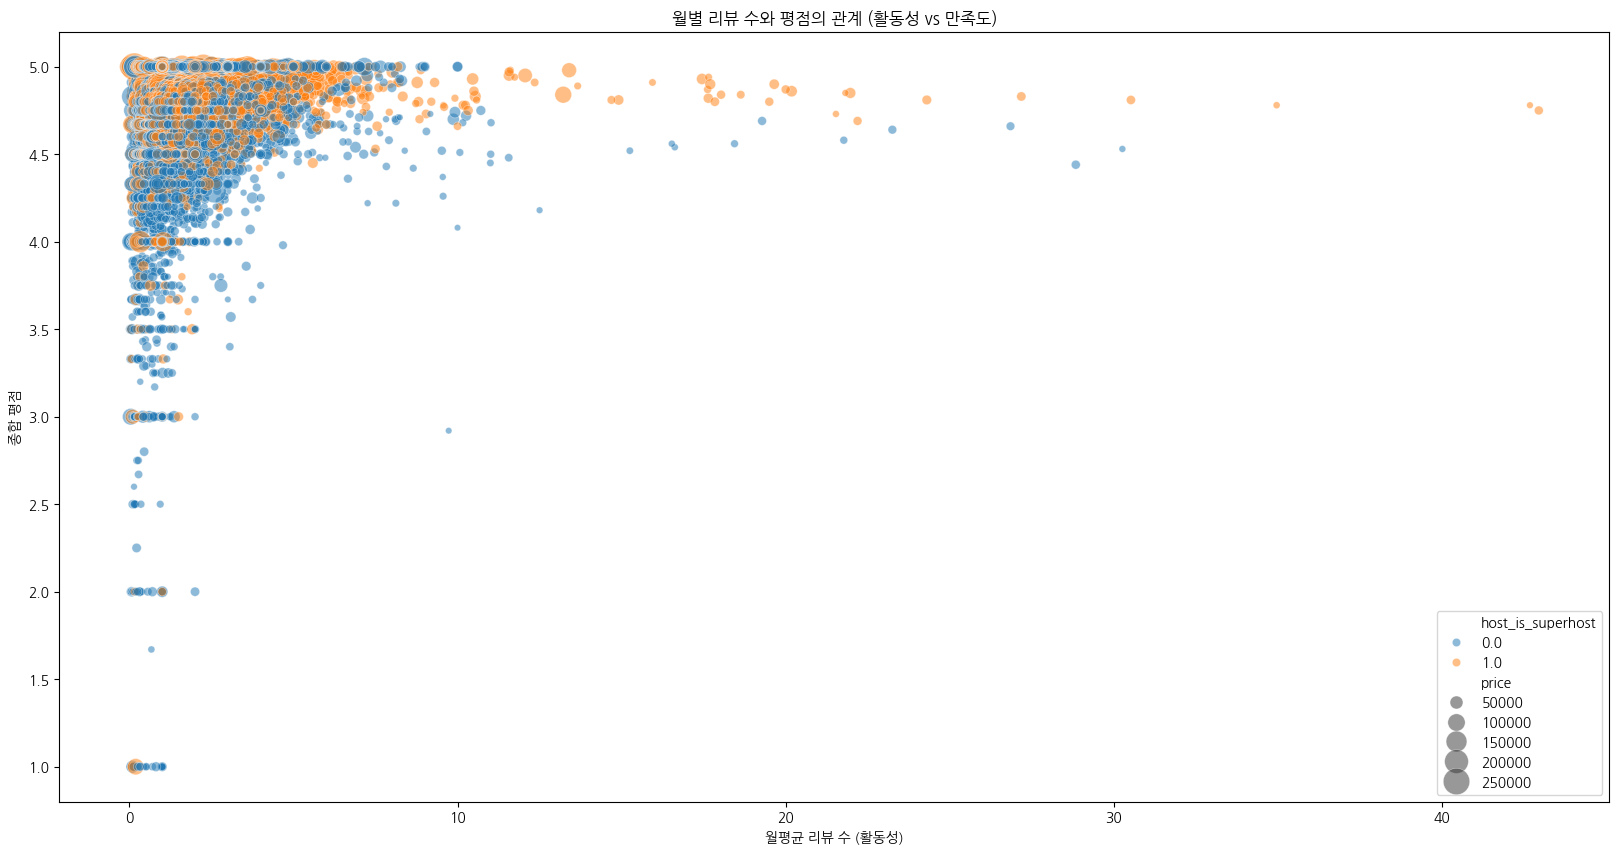

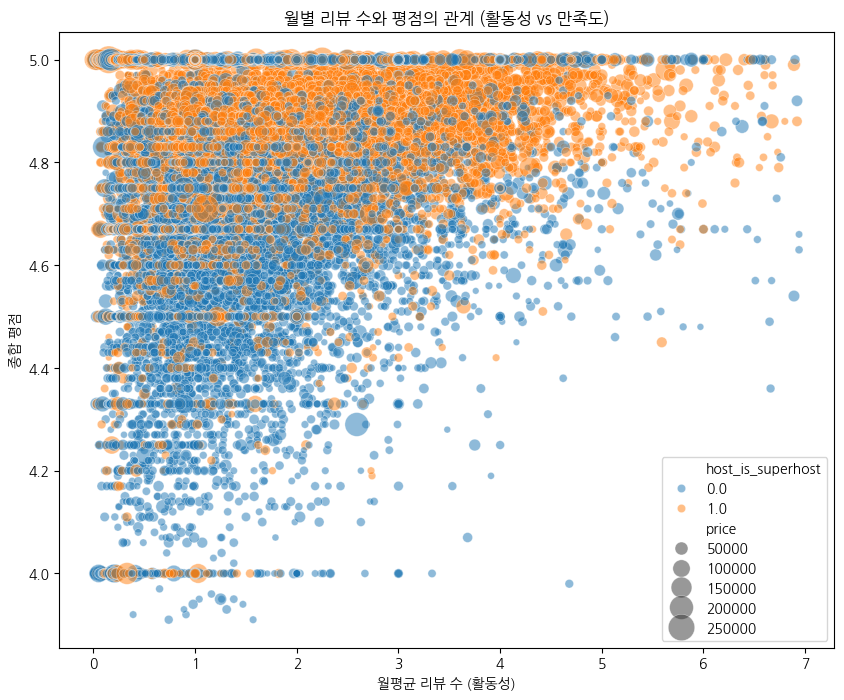

In [31]:
# 최근 1년 리뷰 수와 평점의 관계 (인기 점수 산출)
plt.figure(figsize=(20, 10))
sns.scatterplot(data=listings_df, x='reviews_per_month', y='review_scores_rating', 
                hue='host_is_superhost', size='price', sizes=(20, 400), alpha=0.5)
plt.title('월별 리뷰 수와 평점의 관계 (활동성 vs 만족도)')
plt.xlabel('월평균 리뷰 수 (활동성)')
plt.ylabel('종합 평점')
plt.show()

graphs = listings_df.copy()
graphs = graphs[(graphs['reviews_per_month'] < 7) & (graphs['review_scores_rating'] > 3.9)]
plt.figure(figsize=(10, 8))
sns.scatterplot(data=graphs, x='reviews_per_month', y='review_scores_rating', 
                hue='host_is_superhost', size='price', sizes=(20, 400), alpha=0.5)
plt.title('월별 리뷰 수와 평점의 관계 (활동성 vs 만족도)')
plt.xlabel('월평균 리뷰 수 (활동성)')
plt.ylabel('종합 평점')
plt.show()

<Figure size 1000x600 with 0 Axes>

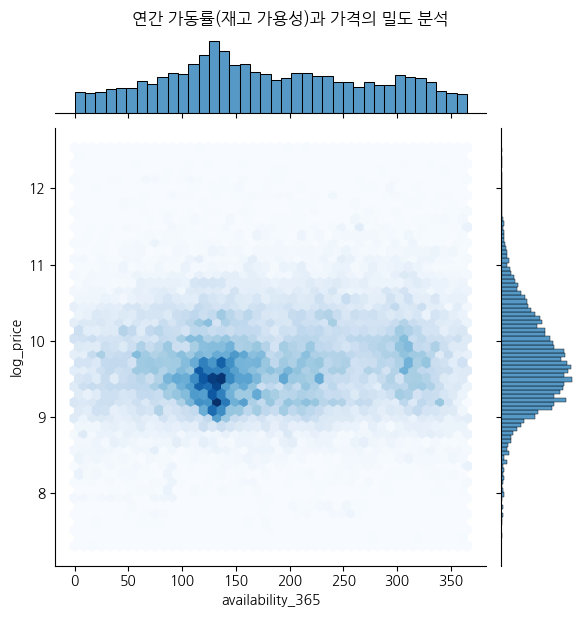

In [27]:
# 가용성(재고)에 따른 가격 전략 분석
# 가용성이 낮을수록(인기가 많을수록) 가격이 비싼지 확인
plt.figure(figsize=(10, 6))
sns.jointplot(data=listings_df, x='availability_365', y='log_price', kind='hex', cmap='Blues')
plt.suptitle('연간 가동률(재고 가용성)과 가격의 밀도 분석', y=1.02)
plt.show()

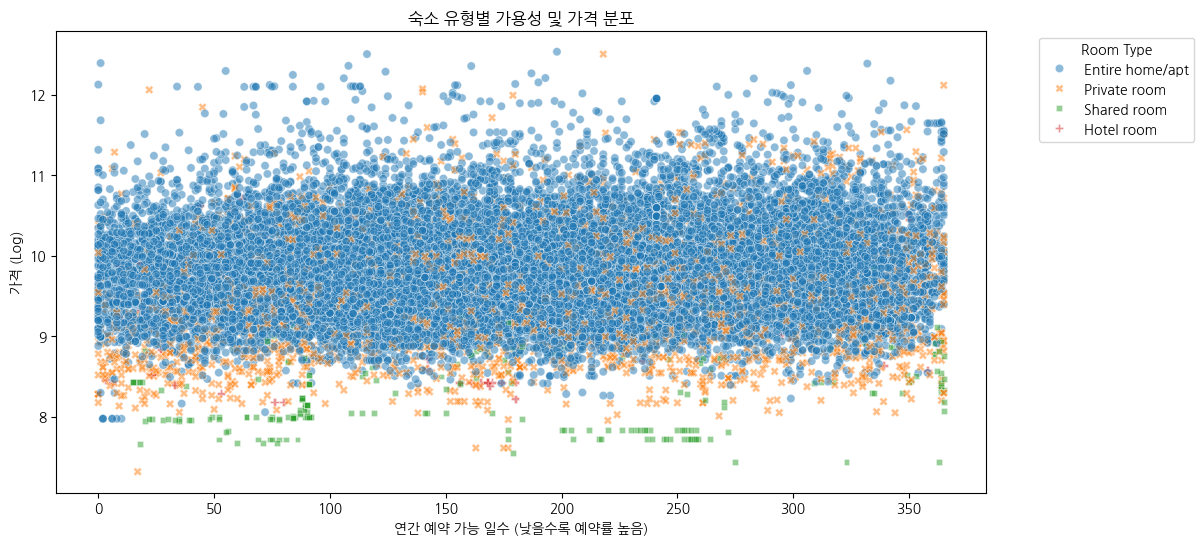

In [28]:
plt.figure(figsize=(12, 6))
# 방 타입별로 가격과 가용성을 동시에 비교
sns.scatterplot(data=listings_df, x='availability_365', y='log_price', 
                hue='room_type', style='room_type', alpha=0.5)
plt.title('숙소 유형별 가용성 및 가격 분포')
plt.xlabel('연간 예약 가능 일수 (낮을수록 예약률 높음)')
plt.ylabel('가격 (Log)')
plt.legend(title='Room Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

C:\Users\songj\AppData\Local\Temp\ipykernel_8304\4041922394.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_ppp_hood.values, y=avg_ppp_hood.index, palette='coolwarm')


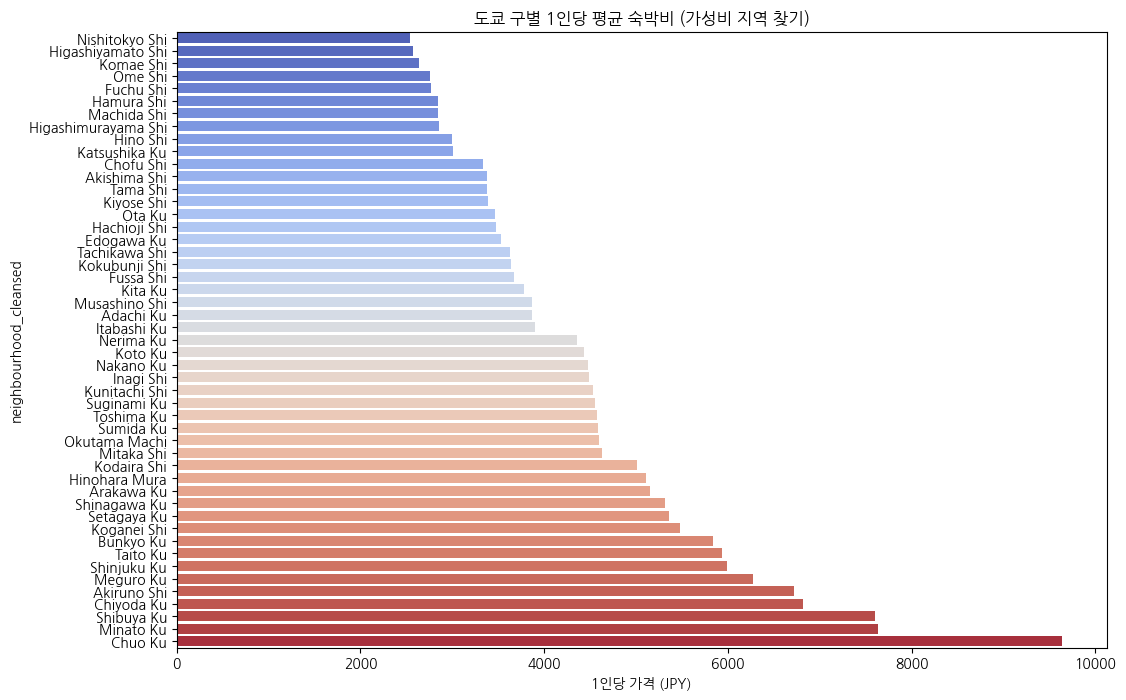

In [29]:
# 1인당 가격 계산
listings_df['price_per_person'] = listings_df['price'] / listings_df['accommodates']

# 지역별 1인당 가격 상위 10개 구 추출
avg_ppp_hood = listings_df.groupby('neighbourhood_cleansed')['price_per_person'].mean().sort_values()

plt.figure(figsize=(12, 8))
sns.barplot(x=avg_ppp_hood.values, y=avg_ppp_hood.index, palette='coolwarm')
plt.title('도쿄 구별 1인당 평균 숙박비 (가성비 지역 찾기)')
plt.xlabel('1인당 가격 (JPY)')
plt.show()

C:\Users\songj\AppData\Local\Temp\ipykernel_8304\4096546564.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=listings_df, x='host_group', y='review_scores_rating', palette='pastel')


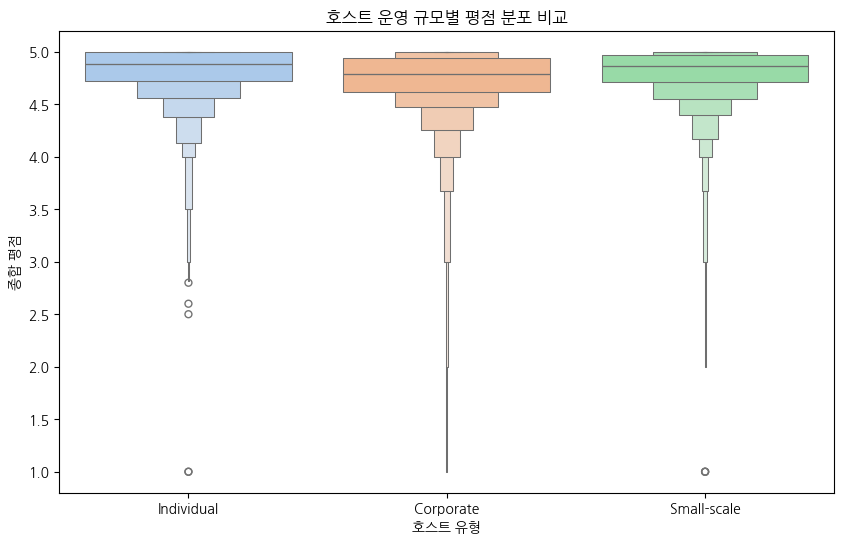

In [30]:
# 호스트 운영 규모 그룹화 (1개: 개인, 2-5개: 중소, 6개 이상: 기업형)
def host_type(count):
    if count == 1: return 'Individual'
    elif count <= 5: return 'Small-scale'
    else: return 'Corporate'

listings_df['host_group'] = listings_df['calculated_host_listings_count'].apply(host_type)

plt.figure(figsize=(10, 6))
sns.boxenplot(data=listings_df, x='host_group', y='review_scores_rating', palette='pastel')
plt.title('호스트 운영 규모별 평점 분포 비교')
plt.xlabel('호스트 유형')
plt.ylabel('종합 평점')
plt.show()

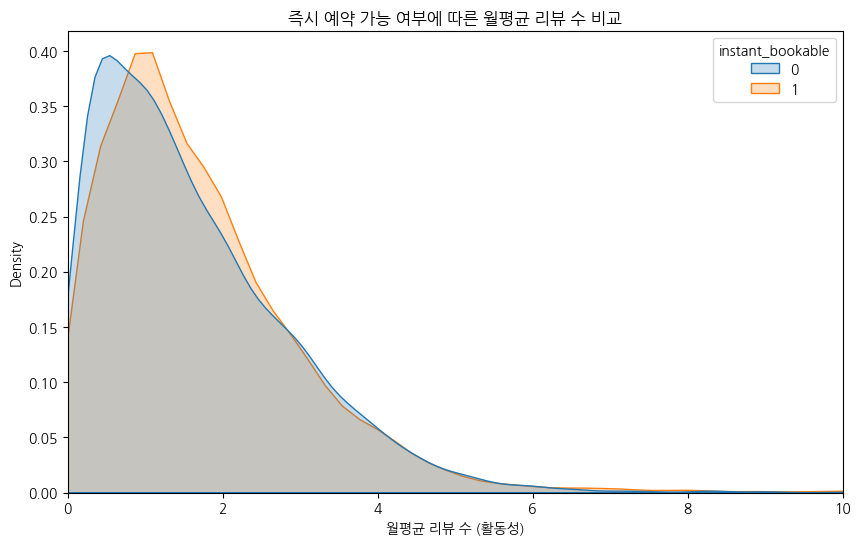

In [31]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=listings_df, x='reviews_per_month', hue='instant_bookable', fill=True, common_norm=False)
plt.xlim(0, 10) # 가독성을 위해 월 리뷰 10개 이하로 제한
plt.title('즉시 예약 가능 여부에 따른 월평균 리뷰 수 비교')
plt.xlabel('월평균 리뷰 수 (활동성)')
plt.show()

발견된 숨은 보석 숙소 수: 1220개
neighbourhood_cleansed
Sumida Ku      170
Toshima Ku     160
Shinjuku Ku    158
Ota Ku          90
Setagaya Ku     89
dtype: int64


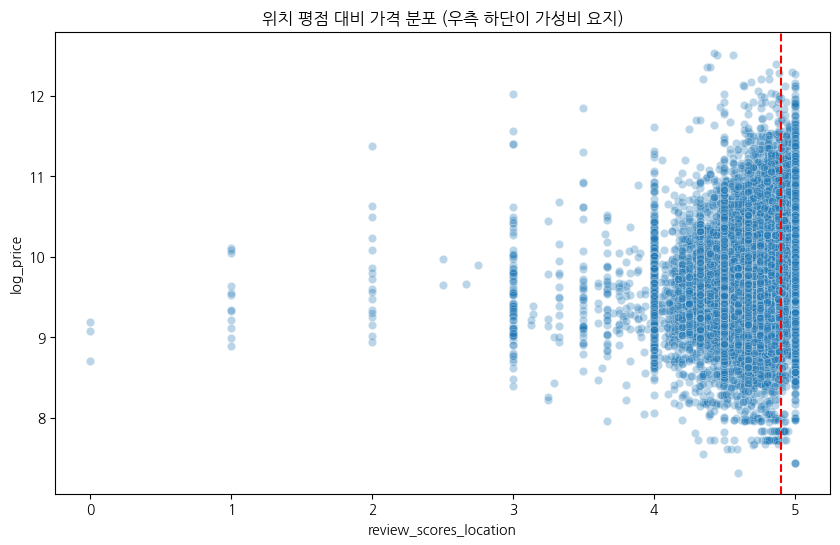

In [32]:
# 위치 평점 4.9 이상이면서 가격은 전체 하위 25%인 숙소 필터링
hidden_gems = listings_df[(listings_df['review_scores_location'] >= 4.9) & 
                          (listings_df['price'] <= listings_df['price'].quantile(0.25))]

print(f"발견된 숨은 보석 숙소 수: {len(hidden_gems)}개")
print(hidden_gems.groupby('neighbourhood_cleansed').size().sort_values(ascending=False).head())

# 시각화: 위치 점수와 가격의 산점도
plt.figure(figsize=(10, 6))
sns.scatterplot(data=listings_df, x='review_scores_location', y='log_price', alpha=0.3)
plt.axvline(4.9, color='red', linestyle='--') # 우측 하단 영역이 Hidden Gems
plt.title('위치 평점 대비 가격 분포 (우측 하단이 가성비 요지)')
plt.show()

C:\Users\songj\AppData\Local\Temp\ipykernel_8304\1915304350.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tightness_by_hood.values[:10], y=tightness_by_hood.index[:10], palette='Reds_r')


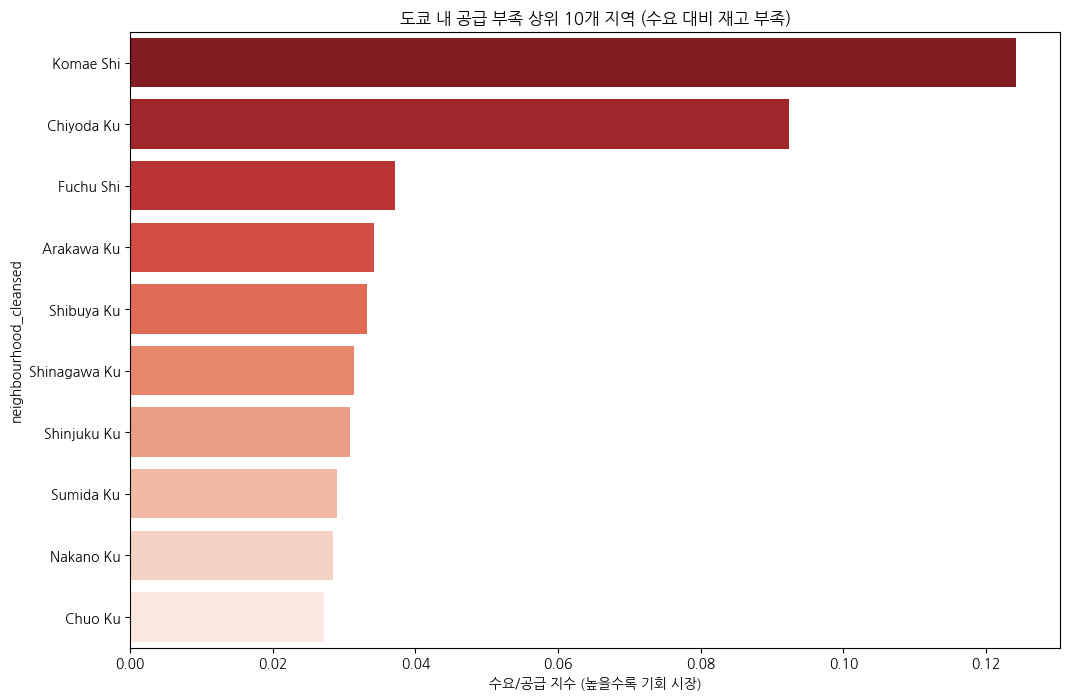

In [33]:
# 수요/공급 지수 계산 (공급이 0인 경우 대비 1 더함)
listings_df['demand_supply_index'] = listings_df['reviews_per_month'] / (listings_df['availability_365'] + 1)

# 지역별 지수 평균
tightness_by_hood = listings_df.groupby('neighbourhood_cleansed')['demand_supply_index'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=tightness_by_hood.values[:10], y=tightness_by_hood.index[:10], palette='Reds_r')
plt.title('도쿄 내 공급 부족 상위 10개 지역 (수요 대비 재고 부족)')
plt.xlabel('수요/공급 지수 (높을수록 기회 시장)')
plt.show()

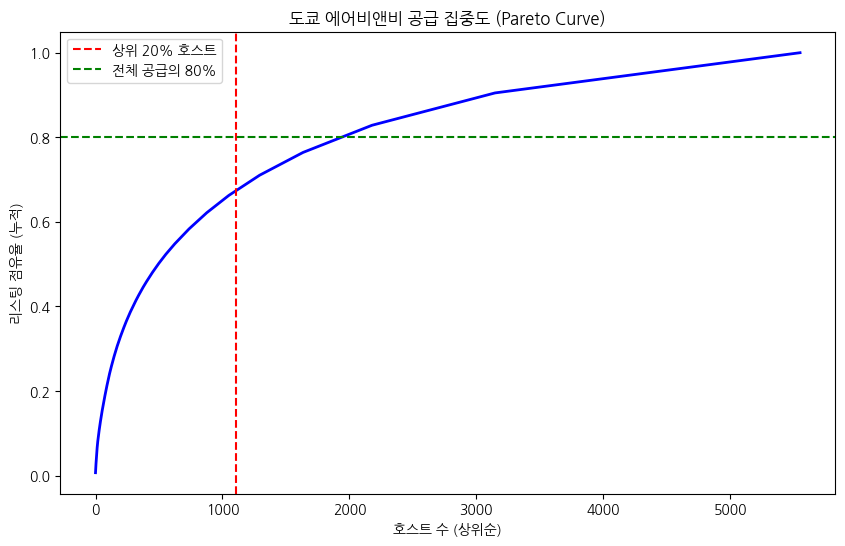

In [34]:
# 호스트별 리스팅 수 계산 및 누적 합계
host_counts = listings_df['host_id'].value_counts().sort_values(ascending=False)
host_cum_ratio = host_counts.cumsum() / host_counts.sum()

plt.figure(figsize=(10, 6))
plt.plot(range(len(host_cum_ratio)), host_cum_ratio.values, color='blue', linewidth=2)
plt.axvline(x=len(host_cum_ratio)*0.2, color='red', linestyle='--', label='상위 20% 호스트')
plt.axhline(y=0.8, color='green', linestyle='--', label='전체 공급의 80%')
plt.title('도쿄 에어비앤비 공급 집중도 (Pareto Curve)')
plt.xlabel('호스트 수 (상위순)')
plt.ylabel('리스팅 점유율 (누적)')
plt.legend()
plt.show()

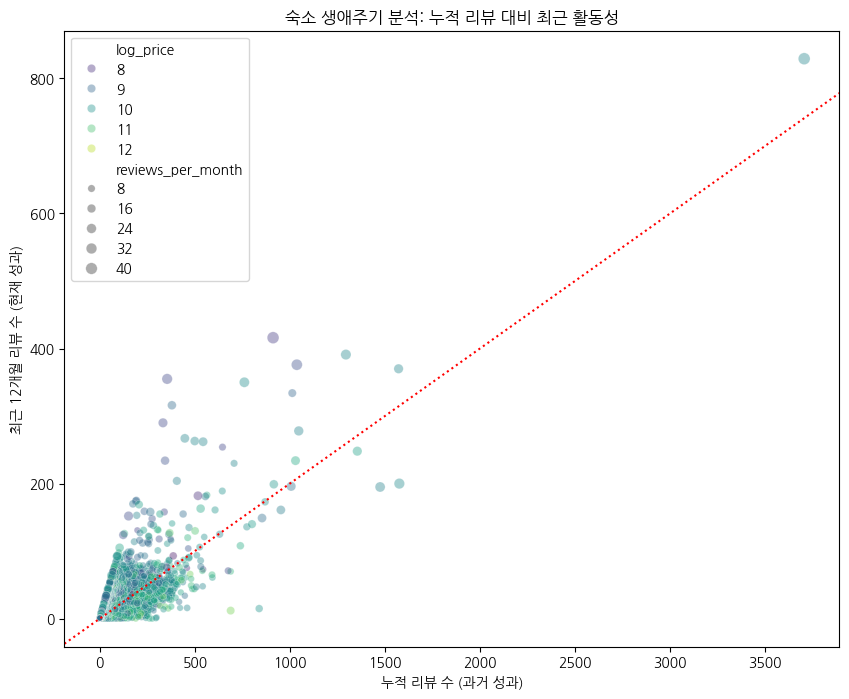

In [35]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=listings_df, x='number_of_reviews', y='number_of_reviews_ltm', 
                hue='log_price', size='reviews_per_month', alpha=0.4, palette='viridis')
plt.axline((0, 0), slope=0.2, color='red', linestyle=':', label='성장/쇠퇴 경계선')
plt.title('숙소 생애주기 분석: 누적 리뷰 대비 최근 활동성')
plt.xlabel('누적 리뷰 수 (과거 성과)')
plt.ylabel('최근 12개월 리뷰 수 (현재 성과)')
plt.show()

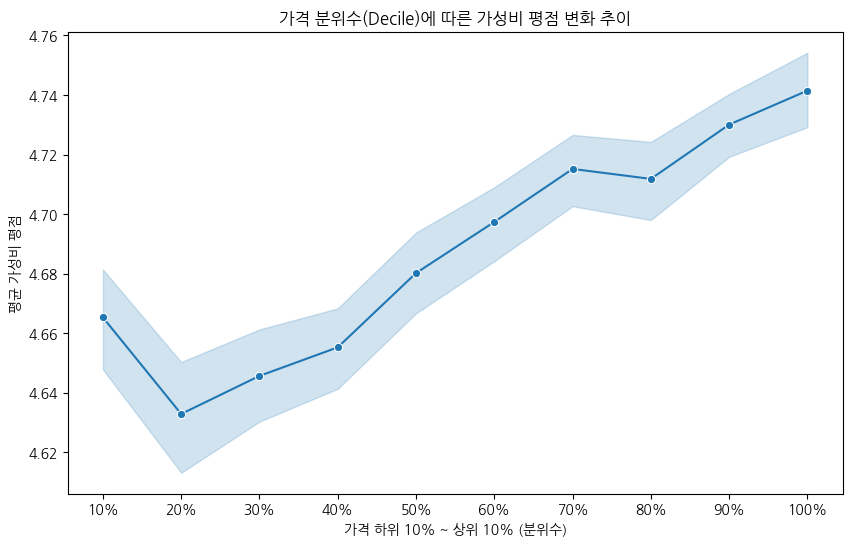

In [36]:
plt.figure(figsize=(10, 6))
# 가격대별 가성비 평점의 추세 확인
sns.lineplot(data=listings_df, x=pd.qcut(listings_df['price'], 10, labels=False), 
             y='review_scores_value', marker='o')
plt.title('가격 분위수(Decile)에 따른 가성비 평점 변화 추이')
plt.xlabel('가격 하위 10% ~ 상위 10% (분위수)')
plt.ylabel('평균 가성비 평점')
plt.xticks(range(10), [f'{i+1}0%' for i in range(10)])
plt.show()

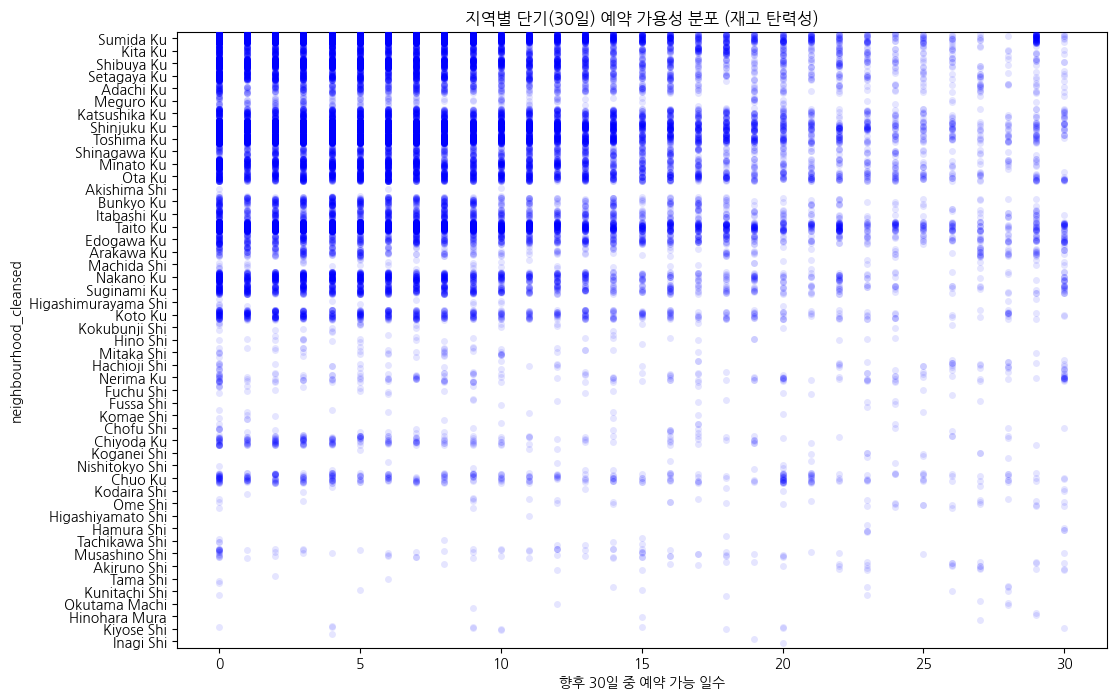

In [37]:
# 지역별 한 달 내 예약 가능 비율
avail_30_stats = listings_df.groupby('neighbourhood_cleansed')['availability_30'].mean().sort_values()

plt.figure(figsize=(12, 8))
sns.stripplot(data=listings_df, x='availability_30', y='neighbourhood_cleansed', 
              jitter=0.4, alpha=0.1, color='blue')
plt.title('지역별 단기(30일) 예약 가용성 분포 (재고 탄력성)')
plt.xlabel('향후 30일 중 예약 가능 일수')
plt.show()